In [1]:
import numpy as np
import pandas as pd

credit = pd.read_csv(r'creditcard.csv')

In [2]:
credit.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
print(f"legit: {credit['Class'].value_counts()[0]/len(credit)}")
print(f"fraud: {credit['Class'].value_counts()[1]/len(credit)}")

legit: 0.9982725143693799
fraud: 0.001727485630620034


(0.0, 172792.0)

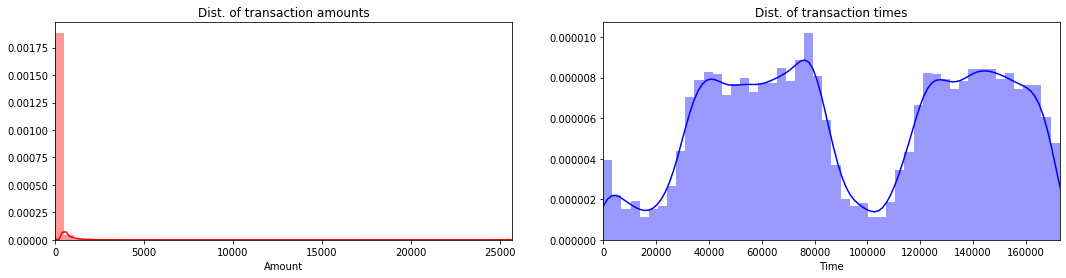

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1, 2, figsize=(18,4))
amounts = credit['Amount']
times = credit['Time']

sns.distplot(amounts, ax=ax[0], color='r')
ax[0].set_title('Dist. of transaction amounts')
ax[0].set_xlim([min(amounts), max(amounts)])

sns.distplot(times, ax=ax[1], color='b')
ax[1].set_title('Dist. of transaction times')
ax[1].set_xlim([min(times), max(times)])

In [20]:
from sklearn.preprocessing import RobustScaler

rob_scaler = RobustScaler()

credit['Scaled_Amount'] = rob_scaler.fit_transform(credit['Amount'].values.reshape(-1,1))
credit['Scaled_Time'] = rob_scaler.fit_transform(credit['Time'].values.reshape(-1,1))

credit.drop(['Time', 'Amount'], axis=1, inplace=True)

In [30]:
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=420)

for train_index, test_index in split.split(credit, credit['Class']):
    train_set = credit.loc[train_index]
    test_set = credit.loc[test_index]

X_train, X_test = train_set.drop('Class', axis=1), test_set.drop('Class', axis=1)
y_train, y_test = train_set.Class, test_set.Class

# Random Under-Sampling

In [43]:
train_set = train_set.sample(frac=1)

fraud = train_set[train_set['Class'] == 1]
legit = train_set[train_set['Class'] == 0][:len(fraud)]

unders_train = pd.concat([fraud, legit])
unders_train = unders_train.sample(frac=1)

X_undersampled, y_undersampled = unders_train.drop('Class', axis=1), unders_train.drop('Class', axis=1)

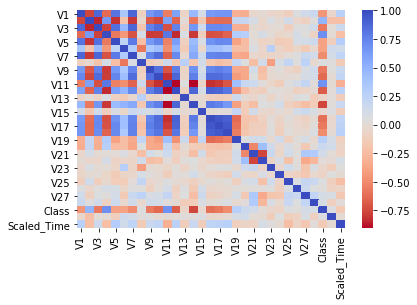

In [50]:
sub_sample_corr = unders_train.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20})
plt.show()

In [154]:
th75 = unders_train.V14.quantile(.75)
th25 = unders_train.V14.quantile(.25)

good_V14 = unders_train[unders_train['V14'] >= th25]
good_V14 = good_V14[good_V14['V14'] <= th75]

In [155]:
good_V14["V14"].describe()

count    394.000000
mean      -2.096065
std        2.175823
min       -6.665177
25%       -4.204956
50%       -0.971912
75%       -0.306968
max        0.126075
Name: V14, dtype: float64

In [156]:
len(unders_train) - len(good_V14)

394

In [157]:
unders_train["V14"].describe()

count    788.000000
mean      -3.511755
std        4.755399
min      -19.214325
25%       -6.668877
50%       -0.971912
75%        0.126243
max        3.442422
Name: V14, dtype: float64

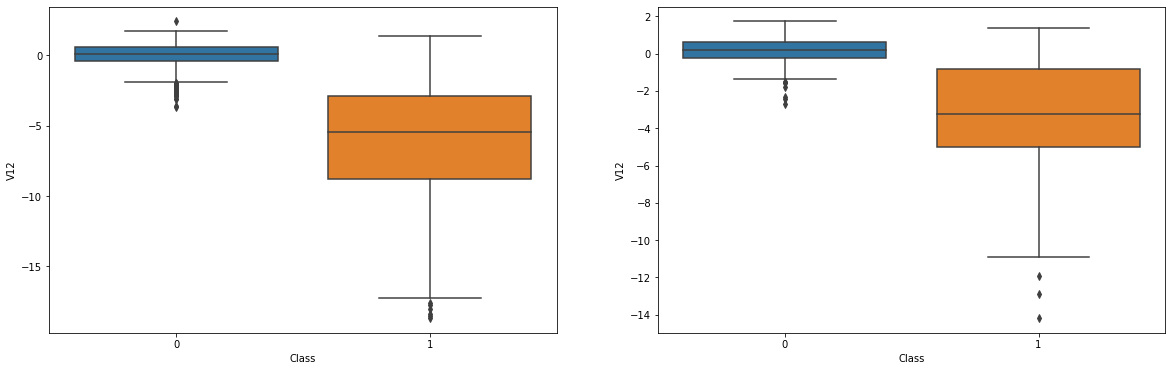

In [158]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))

sns.boxplot(x="Class", y="V12", data=unders_train, ax=ax1)
sns.boxplot(x="Class", y="V12", data=good_V14, ax=ax2)

# Decomposition

In [159]:
new_X = good_V14.drop('Class', axis=1)
new_y = good_V14.Class

In [160]:
from sklearn.decomposition import PCA

pca_undersampled = PCA(n_components=2, whiten=True).fit_transform(new_X)

In [161]:
from sklearn.manifold import TSNE

tnse_undersampled = TSNE(n_components=2, random_state=420).fit_transform(new_X)


Text(0.5, 1.0, 'TMSE')

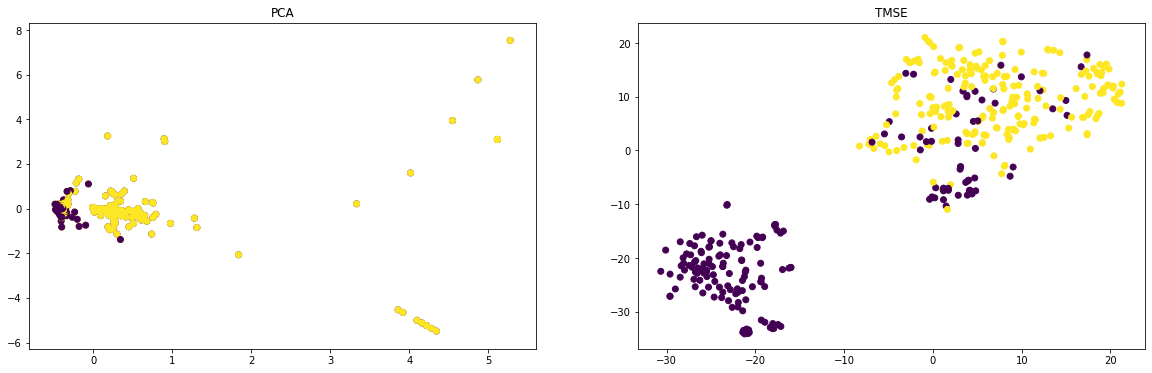

In [174]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))

ax1.scatter(pca_undersampled[:, 0], pca_undersampled[:, 1], c=(new_y == 0), label='No Fraud')
ax1.scatter(pca_undersampled[:, 0], pca_undersampled[:, 1], c=(new_y == 1), label='Fraud')
ax1.set_title("PCA")

ax2.scatter(tnse_undersampled[:, 0], tnse_undersampled[:, 1], c=(new_y == 0))
ax2.set_title('TMSE')

# Classifying

In [175]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [176]:
classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier()
}

In [177]:
from sklearn.model_selection import cross_val_score

scores = {}

for key, classifier in classifiers.items():
    classifier.fit(new_X, new_y)
    tscore = cross_val_score(classifier, new_X, new_y)
    scores.update({key:tscore})
    print(f"score for {key}: {tscore.mean()}")

score for LogisiticRegression: 0.9290165530671859
score for KNearest: 0.9036027263875365
score for Support Vector Classifier: 0.9010061668289516
score for DecisionTreeClassifier: 0.8909769555339176


In [186]:
log_reg = LogisticRegression()
log_reg.fit(new_X, new_y)
predictions = log_reg.predict(X_test)

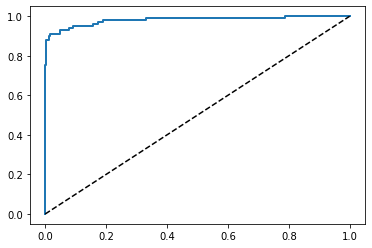

In [188]:
from sklearn.metrics import roc_curve
yscores = log_reg.decision_function(X_test)

fpr, tpr, thresholds = roc_curve(y_test, yscores)

plt.plot(fpr, tpr, linewidth=2)
plt.plot([0,1], [0,1], 'k--')

In [190]:
predictions

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [193]:
from sklearn.metrics import f1_score, confusion_matrix

mrx = confusion_matrix(y_test, predictions)
f1scre = f1_score(y_test, predictions)
print(f1scre)
mrx

0.08922305764411027


array([[55056,  1808],
       [    9,    89]], dtype=int64)